In [2]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data_dir = '/kaggle/input/fruit-recognition/train/train'

In [4]:
dataset = datasets.ImageFolder(root=data_dir)

In [4]:
dataset.classes

['Apple Braeburn',
 'Apple Granny Smith',
 'Apricot',
 'Avocado',
 'Banana',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe',
 'Cherry',
 'Clementine',
 'Corn',
 'Cucumber Ripe',
 'Grape Blue',
 'Kiwi',
 'Lemon',
 'Limes',
 'Mango',
 'Onion White',
 'Orange',
 'Papaya',
 'Passion Fruit',
 'Peach',
 'Pear',
 'Pepper Green',
 'Pepper Red',
 'Pineapple',
 'Plum',
 'Pomegranate',
 'Potato Red',
 'Raspberry',
 'Strawberry',
 'Tomato',
 'Watermelon']

In [5]:
len(dataset.classes)

33

In [7]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, test_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((342, 342)), # Зміна розміру зображення до 342x342 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.CenterCrop((299, 299)),
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # нормалізація для моделей
])

test_transform = transforms.Compose([
    transforms.Resize((342, 342)), # Зміна розміру зображення до 342x342 пікселів
    transforms.CenterCrop((299, 299)),
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # нормалізація для моделей
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        y = torch.tensor(y, dtype=torch.long)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
test_data = TransformDataset(test_data, transform = test_transform)

In [10]:
batch_size = 32

# Створіть завантажувачі даних
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [11]:
from torchvision import models

inception = models.inception_v3(pretrained=True)
inception

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [12]:
in_features = inception.fc.in_features
in_features

2048

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import models

class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Завантажуємо модель Inception V3 з попередньо навченими вагами
        inception = models.inception_v3(pretrained=True)

        # Вимикаємо градієнти для всіх параметрів Inception
        for param in inception.parameters():
            param.requires_grad = False

        # Визначаємо кількість входів для останнього шару (fc)
        in_features = inception.fc.in_features

        # Видаляємо останній шар (fc), заміняючи його на Identity
        inception.fc = nn.Identity()

        # Створення екстрактора ознак (feature extractor)
        self.feature_extractor = inception

        # Додавання своїх власних шарів для класифікації
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # print(f"Input shape before feature extractor: {x.shape}")
        
        # Проходження через feature extractor (Inception)
        x = self.feature_extractor(x)
        
        # Перевірка на наявність logits і aux_logits
        if isinstance(x, tuple):
            # print(f"Shape of logits: {x[0].shape}")  # Основні логіти
            # print(f"Shape of aux_logits: {x[1].shape}")  # Допоміжні логіти
            x = x[0]  # Вибір основних логітів для подальшої обробки
        # else:
            # print(f"Shape after feature extractor: {x.shape}")
        
        x = self.dropout(x)
        # print(f"Shape after dropout: {x.shape}")
        
        x = self.linear(x)
        # print(f"Shape after linear layer: {x.shape}")
        
        return x

    def predict(self, X, device='cpu'):
        # Переводимо вхід X у формат тензора, якщо це необхідно
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(np.array(X)).to(device)
        else:
            X = X.to(device)

        # Виконуємо передбачення без обчислення градієнтів
        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()

# Ініціалізація моделі
model = TransferLearningClassifier(num_classes=len(dataset.classes)).to(device)
model

TransferLearningClassifier(
  (feature_extractor): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )

In [12]:
!pip install -q torchsummary

In [13]:
from torchsummary import summary

summary(model, input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [14]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass
    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()
    
    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)
            
        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)
        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()
        
        # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [15]:
# Визначення функції втрат та оптимізатора

loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (Adam) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
from sklearn.metrics import accuracy_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=50,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TransferLearningClassifier, opt=Adam(lr=0.000100), epochs=50, device=cuda

Epoch    1  163sec	loss:       2.65	val_loss:       1.78	accuracy_score:      0.492	val_accuracy_score:       0.95	
Epoch    2  104sec	loss:       1.45	val_loss:      0.958	accuracy_score:      0.899	val_accuracy_score:      0.978	
Epoch    3  104sec	loss:      0.888	val_loss:       0.57	accuracy_score:      0.945	val_accuracy_score:      0.991	
Epoch    4  104sec	loss:      0.604	val_loss:      0.373	accuracy_score:       0.96	val_accuracy_score:      0.991	
Epoch    5  102sec	loss:      0.459	val_loss:      0.273	accuracy_score:      0.965	val_accuracy_score:      0.993	
Epoch    7  103sec	loss:      0.297	val_loss:      0.159	accuracy_score:      0.976	val_accuracy_score:      0.996	
Epoch    8  103sec	loss:      0.246	val_loss:      0.127	accuracy_score:      0.979	val_accuracy_score:      0.997	
Epoch   10  101sec	loss:      0.189	val_loss:     0.0832	accuracy_score:      0.982	val_acc

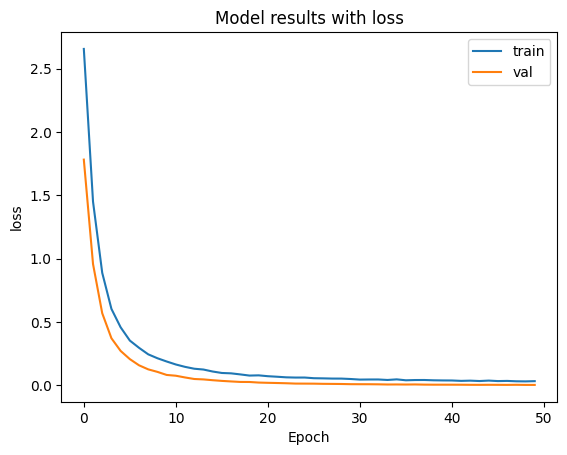

In [17]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

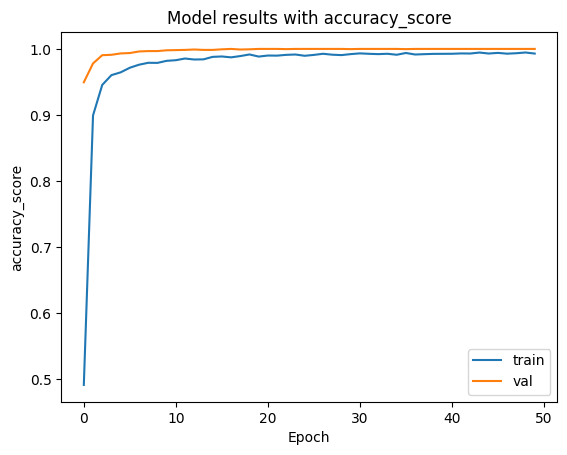

In [18]:
plot_metric(history, 'accuracy_score')

In [1]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # відключаємо від gpu

loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset.classes)
plt.xticks(rotation=90)
plt.plot()

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.argmax(-1), target_names=dataset.classes))